# In-depth analysis Part 2

# Consumer Segmentation Miami

In this section we focus on the data from the Household Pulse Survey to find relationships between shopping variables and demographics, as well as applying Machine Learning techniques to generate customer segmentations.

In [1]:
import pandas as pd
import numpy as np
import indepth_functions
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys
import prince
#!{sys.executable} -m pip install kmodes
from kmodes.kmodes import KModes
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv('../data/interim/census/household_shopping_concat.csv')

In [3]:
df['GENERATION'] = df.TBIRTH_YEAR.apply(indepth_functions.generation_)

## San Francisco

In [4]:
EST_MSA = 33100
name_location = 'Miami-Fort Lauderdale-Pompano Beach'

In [5]:
df_sf = df[df.EST_MSA == EST_MSA]

In [6]:
demographics = ['EGENDER', 'RHISPANIC', 
                    'RRACE',
                    'EEDUC', 'MS', 
                    'THHLD_NUMKID', 'THHLD_NUMADLT', 'INCOME', 'EXPNS_DIF'] 

We ignore the variable `THHLD_NUM` because it's the sum of adults and kids in the household.

In [7]:
shopping_vars = ['ONLINE','PICK-UP','IN-STORE','RFID-NFC', 'CASH', 'AVOID RESTR','RESUME RESTR']

In [8]:
df_sf.rename({'CHNGHOW1': 'ONLINE',
           'CHNGHOW2': 'PICK-UP',
           'CHNGHOW3': 'IN-STORE',
           'CHNGHOW4': 'RFID-NFC', 
           'CHNGHOW5': 'CASH', 
           'CHNGHOW6': 'AVOID RESTR',
           'CHNGHOW7': 'RESUME RESTR'}, axis=1, inplace=True)

In [9]:
df_sf.dropna(subset=demographics, inplace=True)

In [10]:
df_sf = df_sf.replace({np.nan: 0})

In [11]:
df_sf = df_sf.loc[:, demographics+shopping_vars]

In [12]:
df_sf.head()

,EGENDER,RHISPANIC,RRACE,EEDUC,MS,THHLD_NUMKID,THHLD_NUMADLT,INCOME,EXPNS_DIF,ONLINE,PICK-UP,IN-STORE,RFID-NFC,CASH,AVOID RESTR,RESUME RESTR
136,1.0,1.0,1.0,7.0,5.0,0.0,2.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
647,2.0,1.0,2.0,6.0,1.0,0.0,5.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
648,1.0,2.0,1.0,7.0,1.0,2.0,6.0,8.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
653,2.0,1.0,1.0,6.0,3.0,1.0,3.0,8.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
654,2.0,2.0,1.0,3.0,5.0,1.0,2.0,2.0,4.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [13]:
df_sf.value_counts('EEDUC')

EEDUC
6.0    2111
7.0    1866
4.0    1305
5.0     814
3.0     621
2.0     109
1.0      26
dtype: int64

In [14]:
def income_bins(income):
    if income <=3:
        return 1
    elif income >3 and income <=4:
        return 2
    elif income >4 and income <=5:
        return 3
    elif income >5 and income <=6:
        return 4
    else:
        return 5

In [15]:
def educ_bins(educ):
    if educ <=3:
        return 1
    else:
        return educ-2

In [16]:
def kid_bins(kids):
    if kids >=3:
        return 3  
    return kids

In [17]:
def kid_adulsts(adults):
    if adults >=5:
        return 5 
    return adults

In [18]:
def zero_base(value):
    return value-1

In [19]:
df_sf['INCOME'] = df_sf['INCOME'].apply(income_bins)

In [20]:
df_sf['THHLD_NUMKID'] = df_sf['THHLD_NUMKID'].apply(kid_bins)

In [21]:
df_sf['THHLD_NUMADLT'] = df_sf['THHLD_NUMADLT'].apply(kid_adulsts)

In [22]:
df_sf['EEDUC'] = df_sf['EEDUC'].apply(educ_bins)

In [23]:
for col in ['EGENDER', 'RHISPANIC', 'RRACE','EEDUC', 'MS', 'INCOME', 'EXPNS_DIF']:
    df_sf[col] = df_sf[col].apply(zero_base)

In [24]:
df_sf.head()

,EGENDER,RHISPANIC,RRACE,EEDUC,MS,THHLD_NUMKID,THHLD_NUMADLT,INCOME,EXPNS_DIF,ONLINE,PICK-UP,IN-STORE,RFID-NFC,CASH,AVOID RESTR,RESUME RESTR
136,0.0,0.0,0.0,4.0,4.0,0.0,2.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
647,1.0,0.0,1.0,3.0,0.0,0.0,5.0,0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
648,0.0,1.0,0.0,4.0,0.0,2.0,5.0,4,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
653,1.0,0.0,0.0,3.0,2.0,1.0,3.0,4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
654,1.0,1.0,0.0,0.0,4.0,1.0,2.0,0,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [25]:
df_sf1 = df_sf.copy()

In [26]:
# x_cols = df_sf1
# K = np.arange(2, 12, 1)
# inertias = []

# for k in K:
#     model = KMeans(n_clusters=k)
#     model.fit(x_cols)
#     inertias.append(model.inertia_)
    
# f, ax = plt.subplots(figsize=(6.5, 6.5))  
# _ = plt.plot(inertias, linewidth=1, markersize=5, marker='o', linestyle='dashed', color='royalblue') 
# _ = plt.xlabel('clusters')
# _ = plt.ylabel('Sum of Squares')
# _ = plt.title('The Elbow Sum of Squares Method')
# plt.show()

In [54]:
km = KModes(n_clusters=3, init='Huang', n_init=5, verbose=0)
x_cols = df_sf.copy()
clusters = km.fit_predict(x_cols)

# Print the cluster centroids
print(km.cluster_centroids_)

[[1. 0. 0. 3. 4. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 4. 0. 0. 2. 4. 0. 1. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 3. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [55]:
df_sf1['CLUSTER'] = clusters

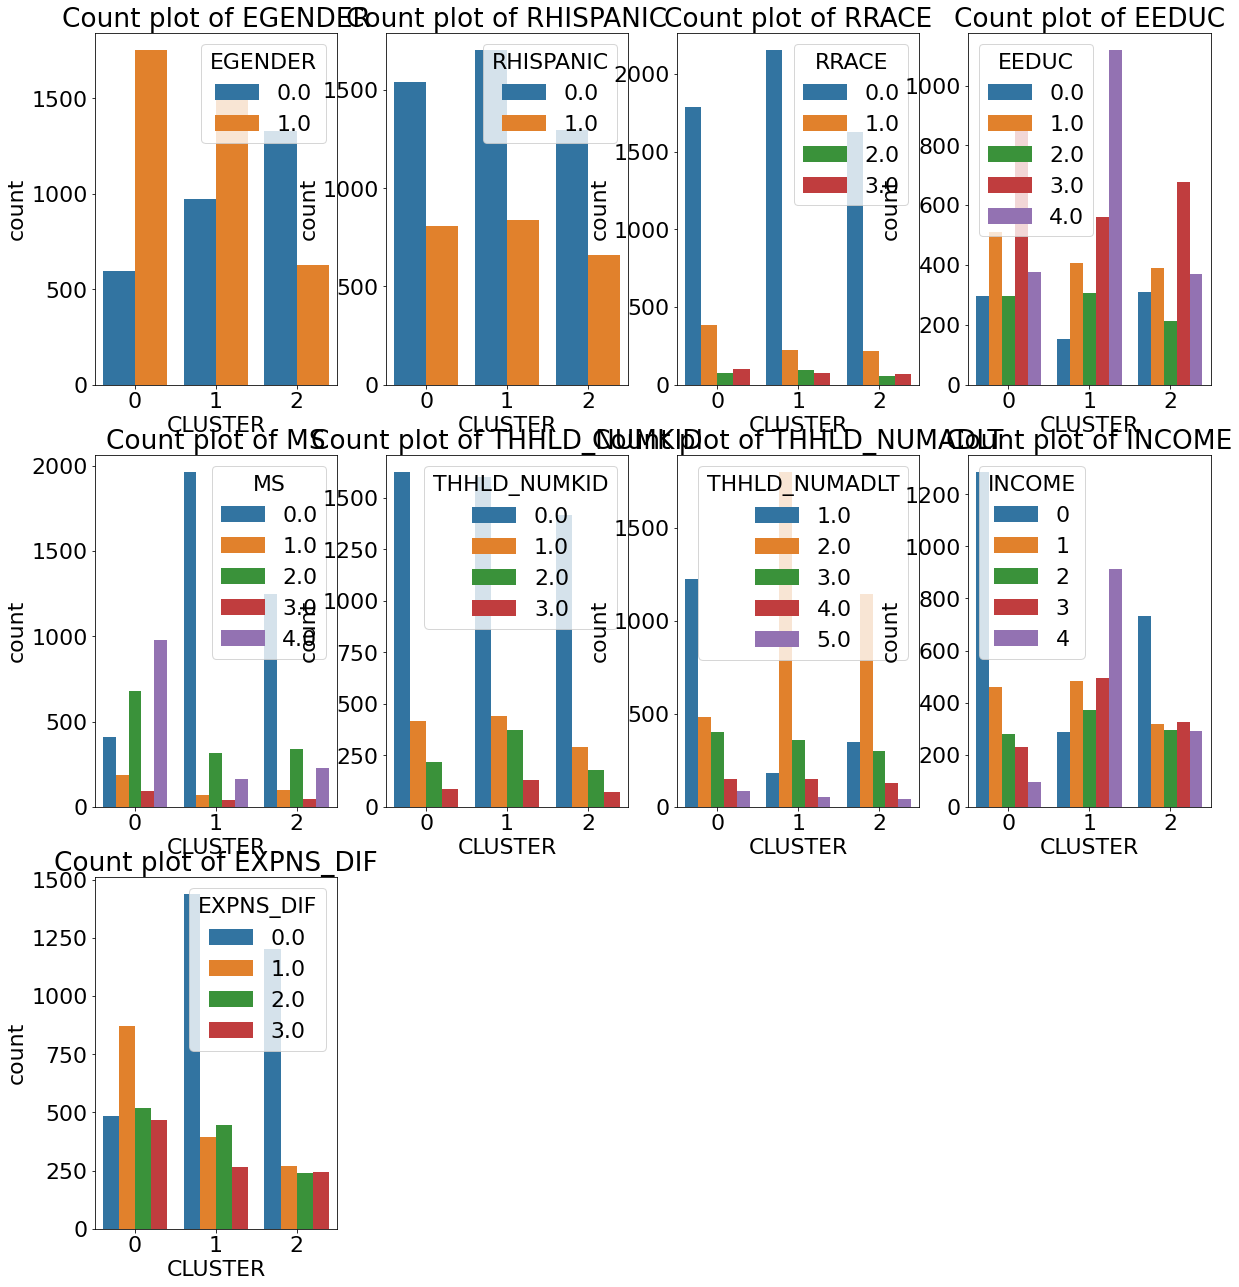

In [56]:
plt.figure(figsize=(20,22))
vars_to_look = demographics
for i, var in enumerate(vars_to_look):
    plt.subplot(3,4,i+1)
    if i ==10:
        plt.xticks(rotation = 90)
    sns.countplot(x='CLUSTER', hue=var, data=df_sf1)
    plt.title("Count plot of " + var)    

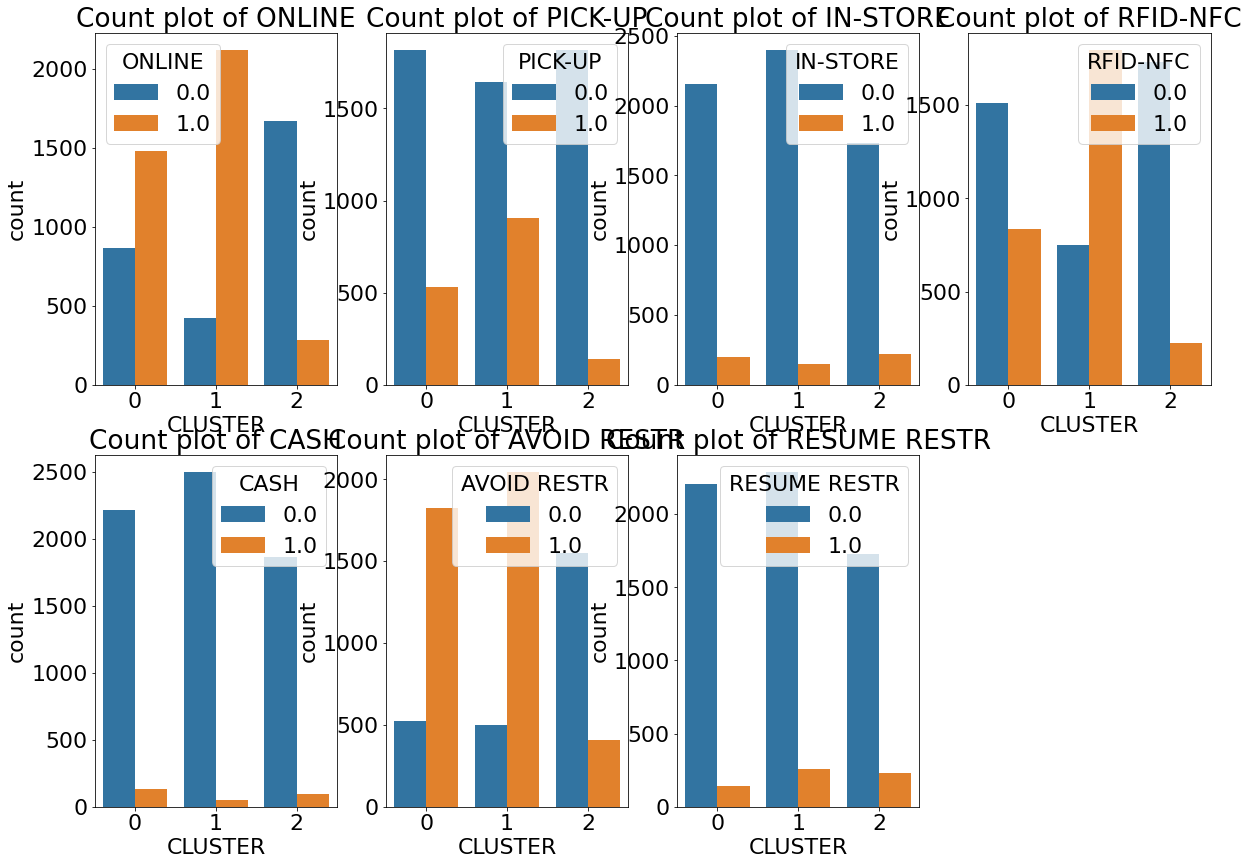

In [57]:
plt.figure(figsize=(20,22))
vars_to_look = shopping_vars
for i, var in enumerate(vars_to_look):
    plt.subplot(3,4,i+1)
    if i ==10:
        plt.xticks(rotation = 90)
    sns.countplot(hue=var, x='CLUSTER', data=df_sf1)
    plt.title("Count plot of " + var)    

In [58]:
def cross_tab(df, var1, var2):
    temp = df.groupby([var1, var2]).count()
    return temp/temp.groupby(level=[0]).sum()*100

In [59]:
for d in demographics:
    df = cross_tab(df_sf1, 'CLUSTER', d)
    print(df)

                 RHISPANIC      RRACE      EEDUC         MS  THHLD_NUMKID  \
CLUSTER EGENDER                                                             
0       0.0      25.255537  25.255537  25.255537  25.255537     25.255537   
        1.0      74.744463  74.744463  74.744463  74.744463     74.744463   
1       0.0      38.256088  38.256088  38.256088  38.256088     38.256088   
        1.0      61.743912  61.743912  61.743912  61.743912     61.743912   
2       0.0      67.977528  67.977528  67.977528  67.977528     67.977528   
        1.0      32.022472  32.022472  32.022472  32.022472     32.022472   

                 THHLD_NUMADLT     INCOME  EXPNS_DIF     ONLINE    PICK-UP  \
CLUSTER EGENDER                                                              
0       0.0          25.255537  25.255537  25.255537  25.255537  25.255537   
        1.0          74.744463  74.744463  74.744463  74.744463  74.744463   
1       0.0          38.256088  38.256088  38.256088  38.256088  38.256

In [60]:
for d in shopping_vars:
    df = cross_tab(df_sf1, 'CLUSTER', d)
    print(df)

                  EGENDER  RHISPANIC      RRACE      EEDUC         MS  \
CLUSTER ONLINE                                                          
0       0.0     36.882453  36.882453  36.882453  36.882453  36.882453   
        1.0     63.117547  63.117547  63.117547  63.117547  63.117547   
1       0.0     16.614297  16.614297  16.614297  16.614297  16.614297   
        1.0     83.385703  83.385703  83.385703  83.385703  83.385703   
2       0.0     85.444331  85.444331  85.444331  85.444331  85.444331   
        1.0     14.555669  14.555669  14.555669  14.555669  14.555669   

                THHLD_NUMKID  THHLD_NUMADLT     INCOME  EXPNS_DIF    PICK-UP  \
CLUSTER ONLINE                                                                 
0       0.0        36.882453      36.882453  36.882453  36.882453  36.882453   
        1.0        63.117547      63.117547  63.117547  63.117547  63.117547   
1       0.0        16.614297      16.614297  16.614297  16.614297  16.614297   
        1.0    

In [61]:
def get_rct(var1, var2, df):
    res = pd.crosstab(df[var2], df[var1])
    output = round( res.div(res.sum(axis = 1),axis = 0)*100, 2 )
    return output

In [62]:
# df1 = get_rct('ONLINE', 'CLUSTER', df_sf)
# df1=df1.reset_index()

In [63]:
#df1.merge(df2)

In [64]:
# df2 = get_rct('IN-STORE', 'CLUSTER', df_sf)
# df2=df2.reset_index()

In [65]:
#pd.concat([df1, df2], axis=1, keys=[0, 1, 2])

In [66]:
x_cols.columns

Index(['EGENDER', 'RHISPANIC', 'RRACE', 'EEDUC', 'MS', 'THHLD_NUMKID',
       'THHLD_NUMADLT', 'INCOME', 'EXPNS_DIF', 'ONLINE', 'PICK-UP', 'IN-STORE',
       'RFID-NFC', 'CASH', 'AVOID RESTR', 'RESUME RESTR'],
      dtype='object')

In [67]:
for col in list(x_cols.columns):
    x_cols[col] = x_cols[col].astype('category')

In [68]:
x_cols[['EGENDER', 'RHISPANIC', 'RRACE', 'EEDUC', 'MS', 'THHLD_NUMKID',
       'THHLD_NUMADLT', 'INCOME', 'EXPNS_DIF', 'ONLINE', 'PICK-UP', 'IN-STORE',
       'RFID-NFC', 'CASH', 'AVOID RESTR', 'RESUME RESTR']]

,EGENDER,RHISPANIC,RRACE,EEDUC,MS,THHLD_NUMKID,THHLD_NUMADLT,INCOME,EXPNS_DIF,ONLINE,PICK-UP,IN-STORE,RFID-NFC,CASH,AVOID RESTR,RESUME RESTR
136,0.0,0.0,0.0,4.0,4.0,0.0,2.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
647,1.0,0.0,1.0,3.0,0.0,0.0,5.0,0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
648,0.0,1.0,0.0,4.0,0.0,2.0,5.0,4,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
653,1.0,0.0,0.0,3.0,2.0,1.0,3.0,4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
654,1.0,1.0,0.0,0.0,4.0,1.0,2.0,0,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705592,1.0,1.0,0.0,1.0,2.0,0.0,2.0,1,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
705593,1.0,1.0,0.0,4.0,0.0,0.0,3.0,0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
705594,0.0,0.0,0.0,3.0,0.0,2.0,3.0,3,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
705596,0.0,1.0,0.0,2.0,3.0,0.0,2.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
x_cols1 = x_cols[['EGENDER', 'RHISPANIC', 'RRACE', 'EEDUC', 'MS', 'THHLD_NUMKID',
       'THHLD_NUMADLT', 'INCOME', 'EXPNS_DIF', 'ONLINE', 'PICK-UP', 'IN-STORE',
       'RFID-NFC', 'CASH', 'AVOID RESTR', 'RESUME RESTR']]

In [43]:
mca = prince.MCA(n_components=2,n_iter=3,copy=True,check_input=True,engine='auto',random_state=42)
mca = mca.fit(x_cols1)

In [44]:
mca.total_inertia_

2.125

In [45]:
mca.eigenvalues_

[0.14557568706265742, 0.12734034963276122]

In [46]:
mca.explained_inertia_

[0.06850620567654467, 0.059924870415417046]

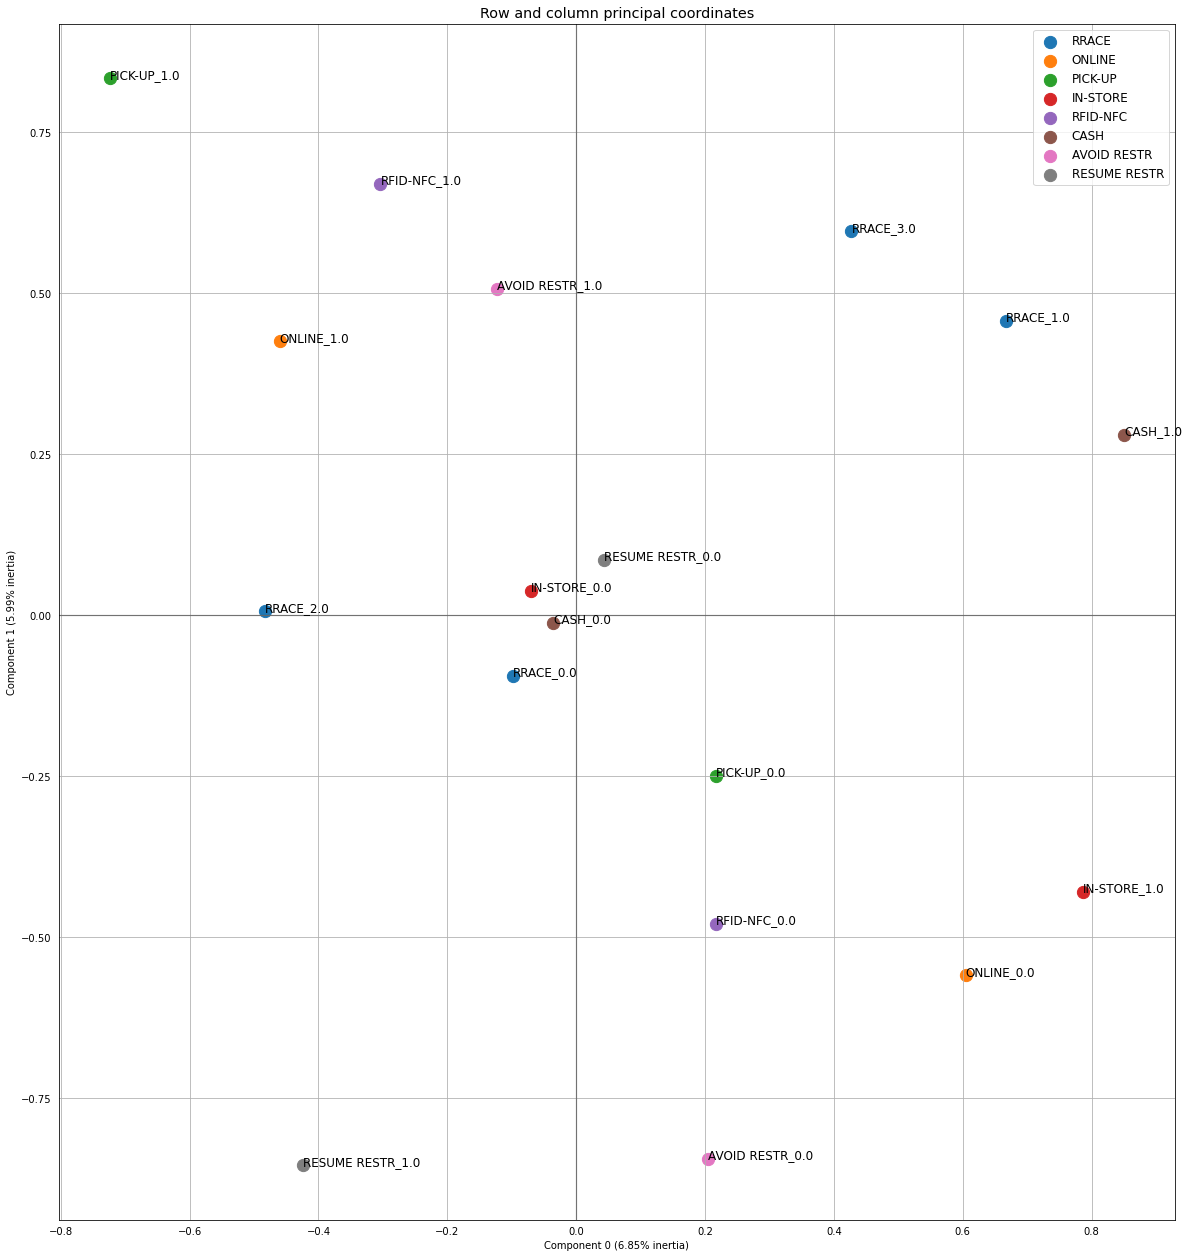

In [47]:
fig, ax = plt.subplots(figsize=(20,22))
# _ = plt.xlim((-0.5, 0.5))   # set the xlim to left, right
# _ = plt.ylim(-0.5, 0.5)     # set the xlim to left, right
_ = plt.rcParams.update({'font.size': 12})
ax = mca.plot_coordinates(X=x_cols1[['RRACE', 'ONLINE', 'PICK-UP', 'IN-STORE',
       'RFID-NFC', 'CASH', 'AVOID RESTR', 'RESUME RESTR']],
                          ax=ax,figsize=(6, 6), 
                          show_row_points=False,
                          row_points_size=10,
                          show_row_labels=False,
                          show_column_points=True,
                          column_points_size=150,
                          show_column_labels=True)
#ax.get_figure().savefig('images/mca_coordinates.svg')

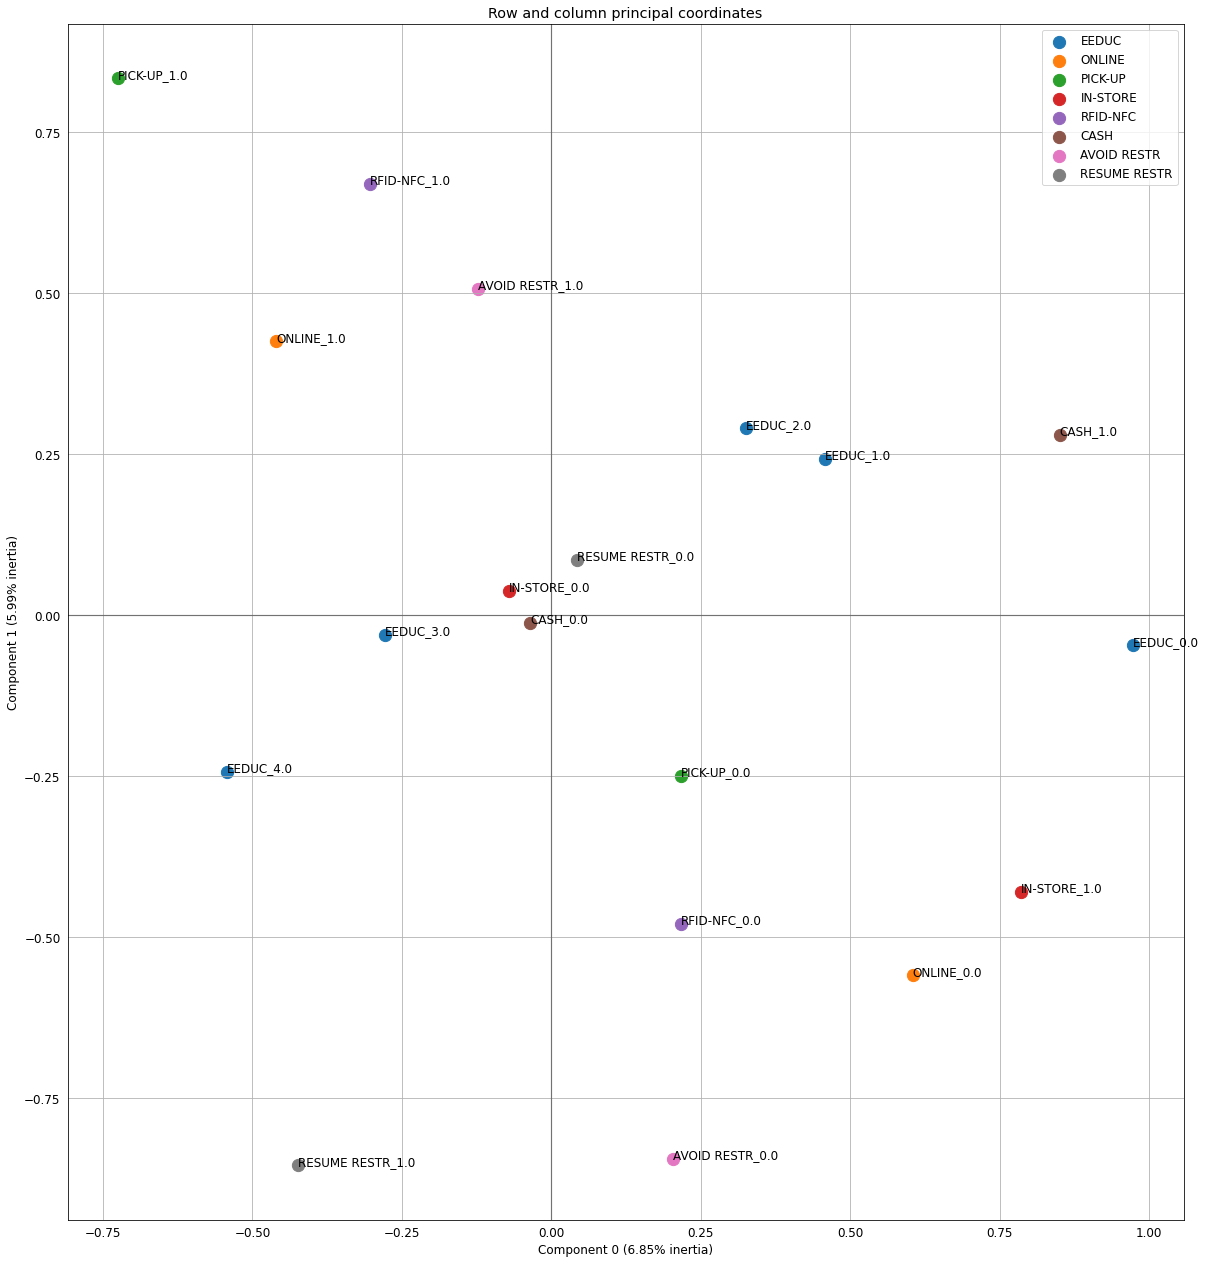

In [48]:
fig, ax = plt.subplots(figsize=(20,22))
# _ = plt.xlim((-0.5, 0.5))   # set the xlim to left, right
# _ = plt.ylim(-0.5, 0.5)     # set the xlim to left, right
_ = plt.rcParams.update({'font.size': 12})
ax = mca.plot_coordinates(X=x_cols1[['EEDUC', 'ONLINE', 'PICK-UP', 'IN-STORE',
       'RFID-NFC', 'CASH', 'AVOID RESTR', 'RESUME RESTR']],
                          ax=ax,figsize=(6, 6), 
                          show_row_points=False,
                          row_points_size=10,
                          show_row_labels=False,
                          show_column_points=True,
                          column_points_size=150,
                          show_column_labels=True)
#ax.get_figure().savefig('images/mca_coordinates.svg')

In [49]:
mca.row_coordinates(x_cols1)

,0,1
136,-0.157767,-0.708033
647,0.503670,0.180078
648,-0.559566,0.265603
653,-0.154241,-0.264920
654,0.493025,0.374737
...,...,...
705592,0.088107,0.486622
705593,-0.106476,0.400467
705594,-0.358435,0.165606
705596,0.277883,-0.307767


In [50]:
df2 = mca.row_coordinates(x_cols1).copy()

In [51]:
df2.iloc[:, 1]

136      -0.708033
647       0.180078
648       0.265603
653      -0.264920
654       0.374737
            ...   
705592    0.486622
705593    0.400467
705594    0.165606
705596   -0.307767
705597    0.089083
Name: 1, Length: 6852, dtype: float64

In [52]:
mca.row_coordinates(x_cols1).iloc[:, 0]

136      -0.157767
647       0.503670
648      -0.559566
653      -0.154241
654       0.493025
            ...   
705592    0.088107
705593   -0.106476
705594   -0.358435
705596    0.277883
705597   -0.482785
Name: 0, Length: 6852, dtype: float64

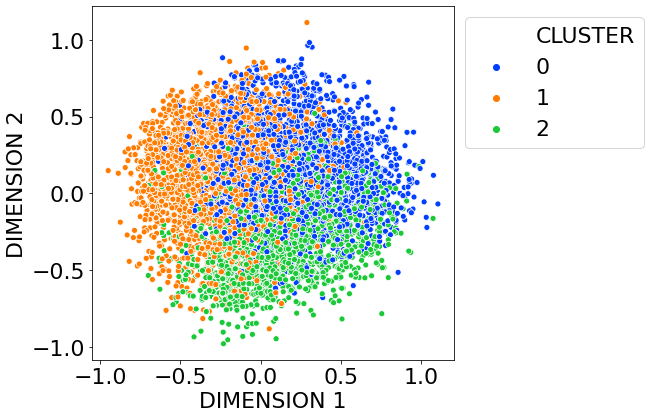

In [69]:
# from sklearn.decomposition import PCA

# pca_sf = PCA(n_components=2)
# points = pca_sf.fit_transform(x_cols)

# print(pca_sf.explained_variance_ratio_)


df_sf1['DIMENSION X'] = df2.iloc[:, 0]
df_sf1['DIMENSION Y'] = df2.iloc[:, 1]

fig, ax = plt.subplots(figsize=(6.5, 6.5))

#legend = ['GROUP A','GROUP B', 'GROUP C', 'GROUP D']
palette = sns.color_palette("bright", 3)  #Choosing color
_ = plt.rcParams.update({'font.size': 22})
_ = sns.scatterplot(x='DIMENSION X', y='DIMENSION Y', data=df_sf1, hue='CLUSTER', palette=palette)
_ = plt.xlabel('DIMENSION 1')
_ = plt.ylabel('DIMENSION 2')
_ = ax.legend(bbox_to_anchor=(1.0, 1.0))
# ax.text(-5, 2.5, 'GROUP 2')
# ax.text(3, -2.5, 'GROUP 1')
# ax.text(-4, -2.5, 'GROUP 0')
# ax.text(3, 5, 'GROUP 3')
plt.show()